# Rotary Positional Encodings

## Why do we need positional embeddings in the first place?
The transformer architecture is permutation invariant, meaning that the order of the input tokens does not matter. This is a problem for tasks like language modeling, where the order of the words is important. To solve this problem, the transformer architecture uses positional embeddings to encode the position of the tokens in the input sequence.

Vocabulary is just a set of tokens, for example:
"The dog chased the pig" has the same tokens as "The pig chased the dog". or "chased pig The the dog"

If we can to preserve the order of the tokens, we need to add some information about the position of the tokens in the input sequence. This is done using positional embeddings.

## Absolute vs Relative Positional Encodings

### Absolute Positional Encodings:
Every position in the input sequence is assigned a unique embedding. to combine the token and positional embeddings, we add them together.
This forces the model to learn the position of the tokens in the input sequence from data. This is problematic because the max length is bounded by the max sequence length in the training data.

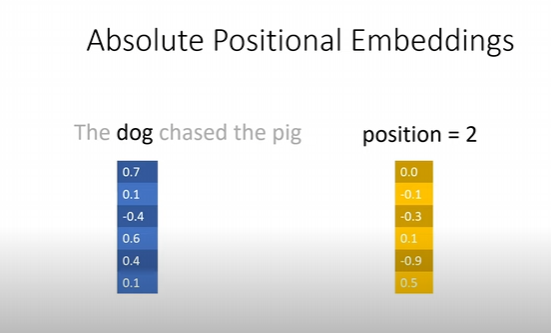

Another way to do this is using the sinusoidal positional embeddings, which is the default in the original transformer paper. In the real world they perform similarly.

Another problem is that positional embeddings are independent from each other. For example, token 1 and token 2 have a lot more in common than token 1 and token 1000.

### Relative Positional Encodings:
Learn the tokens' position relative to each other. An example of this is done with T5. 

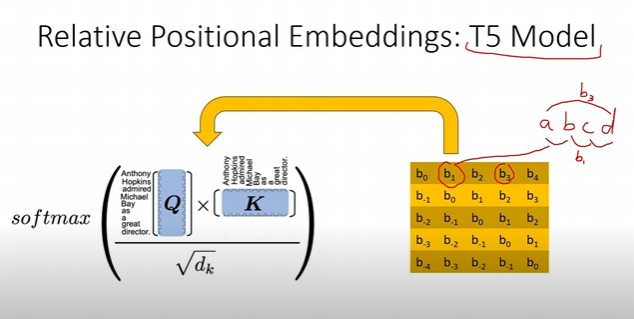

One benefit of this is the the same bias weight represents absolute position and extend to arbitrary length. This process is very slow and doesn't scale well.

## Rotary Positional Encodings:

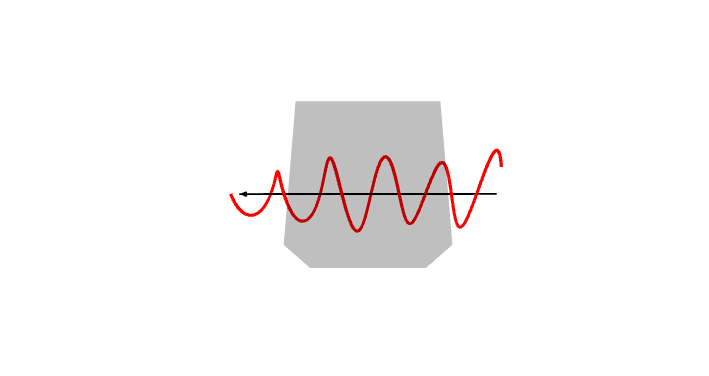

The rotary positional embeddings take the original token vector and rotate it by a multiple angle depending on the position of the token in the input sequence.

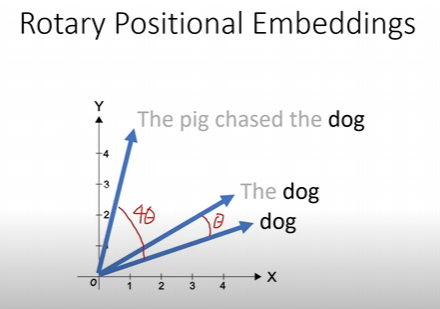

This has a lot of the benefits of absolute embeddings. If you add more tokens to the end of a sentence, the model doesn't need to relearn the position of the tokens in the input sequence.

The angle between words is preserved if words are added to the beginning and end:

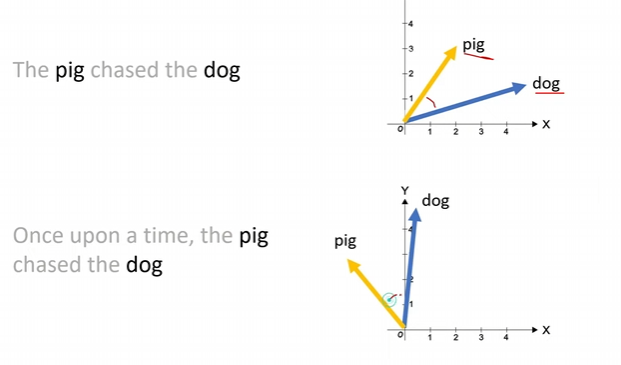


## Why do we care?
RoPE is an encoder used in models like Llama and Gemma as well as Gemini.

References:

(Rotary Positional Embeddings: Combining Absolute and Relative)[https://www.youtube.com/watch?v=o29P0Kpobz0&t=54s&ab_channel=EfficientNLP]

(Coding LLaMA 2 from scratch in PyTorch - KV Cache, Grouped Query Attention, Rotary PE, RMSNorm)[https://www.youtube.com/watch?v=oM4VmoabDAI&ab_channel=UmarJamil]

(RoFormer: Enhanced Transformer with Rotary Position Embedding)[https://arxiv.org/abs/2104.09864]

(Rotary Embeddings: A Relative Revolution)[https://blog.eleuther.ai/rotary-embeddings/]


# The RoPE Formula

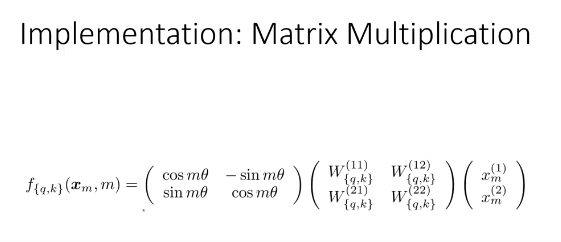

* m: The absolute position of the token in the input sequence
* theta: The rotation angle
* x: The token vector (in this example it's a 2-dimensional vector)

However the practical way to apply this is to use the following formula:

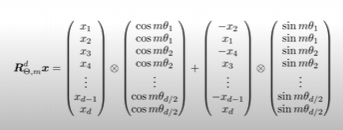


Oh, FYI, the rotary embedding is used in the attention mechanism, not in the token embedding.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def compute_rotary_positional_frequencies(head_dim: int, seq_len: int, device: str, theta: float = 10000.0):
    """
    Computes the rotational frequencies for positional embeddings.

    Usually set in the constructor of the model, these frequencies are used to compute the positional embeddings

    Args:
        head_dim (int): Dimensionality of each attention head.
        seq_len (int): Length of the sequence.
        device (str): Device to place the tensors (e.g., 'cpu', 'cuda').
        theta (float, optional): Scaling factor for the rotational frequencies (default is 10000.0).

    Returns:
        torch.Tensor: Tensor containing the precomputed rotational frequencies as complex numbers.
    """
    assert head_dim % 2 == 0, "Dimension must be divisible by 2" # cannot be odd

    # Build the theta parameter
    # According to the formula theta_i = 10000^(-2(i-1)/dim) for i = [1, 2, ... dim/2]
    # Shape: (Head_Dim / 2)
    theta_numerator = torch.arange(0, head_dim, 2).float()
    # Shape: (Head_Dim / 2)
    theta = 1.0 / (theta ** (theta_numerator / head_dim)).to(device)

    # Construct the positions (the "m" parameter)
    # Shape: (Seq_Len)
    m = torch.arange(seq_len, device=device)

    # Multiply each theta by each position using the outer product.
    # Shape: (Seq_Len) outer_product* (Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    freqs_real = torch.outer(m, theta).float()

    # We can compute complex numbers in the polar form c = R * exp(m * theta), where R = 1 as follows:
    # (Seq_Len, Head_Dim / 2) -> (Seq_Len, Head_Dim / 2)
    rotary_frequencies = torch.polar(torch.ones_like(freqs_real), freqs_real)

    return rotary_frequencies

In [3]:
def rotary_positional_embeddings(x: torch.Tensor, rotary_frequencies: torch.Tensor, device: torch.device):
    """
    Applies rotary positional embeddings to the input tensor.

    This function takes an input tensor `x` representing the embeddings and applies
    rotary positional embeddings based on the provided `rotary_frequencies`.

    Args:
        x (torch.Tensor): Input tensor of shape (B, Seq_Len, H, Head_Dim).
        rotary_frequencies (torch.Tensor): Tensor containing the rotational frequencies
            as complex numbers. It should have the shape (Seq_Len, Head_Dim/2).
        device (torch.device): Device to place the tensors (e.g., 'cpu', 'cuda').

    Returns:
        torch.Tensor: Tensor containing the rotated positional embeddings.
            It has the same shape as the input tensor `x`, (B, Seq_Len, H, Head_Dim).
    """
    # Separate the last dimension pairs of two values, representing the real and imaginary parts of the complex number
    # Two consecutive values will become a single complex number
    # (B, Seq_Len, H, Head_Dim) -> (B, Seq_Len, H, Head_Dim/2)
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))
    # Reshape the freqs_complex tensor to match the shape of the x_complex tensor. So we need to add the batch dimension and the head dimension
    # (Seq_Len, Head_Dim/2) --> (1, Seq_Len, 1, Head_Dim/2)
    rotary_frequencies = rotary_frequencies.unsqueeze(0).unsqueeze(2)
    # Multiply each complex number in the x_complex tensor by the corresponding complex number in the freqs_complex tensor
    # Which results in the rotation of the complex number as shown in the Figure 1 of the paper
    # (B, Seq_Len, H, Head_Dim/2) * (1, Seq_Len, 1, Head_Dim/2) = (B, Seq_Len, H, Head_Dim/2)
    x_rotated = x_complex * rotary_frequencies
    # Convert the complex number back to the real number
    # (B, Seq_Len, H, Head_Dim/2) -> (B, Seq_Len, H, Head_Dim/2, 2)
    x_out = torch.view_as_real(x_rotated)
    # (B, Seq_Len, H, Head_Dim/2, 2) -> (B, Seq_Len, H, Head_Dim)
    x_out = x_out.reshape(*x.shape)
    return x_out.type_as(x).to(device)

In [4]:
# sample usage
# Step 1: Generate Input Data
head_dim = 16
seq_len = 10
device = torch.device('cpu')  # or 'cuda' if available
theta = 10000.0  # Optional parameter for compute_rotary_positional_frequencies

# Generate example input tensor
x = torch.randn(2, seq_len, 1, head_dim)

# Step 2: Compute Rotational Frequencies
rotary_frequencies = compute_rotary_positional_frequencies(head_dim, seq_len, device, theta)

# Step 3: Apply Rotary Positional Embeddings
rotated_embeddings = rotary_positional_embeddings(x, rotary_frequencies, device)

# Step 4: Check Results
# Ensure the output tensor has the same shape as the input tensor
assert rotated_embeddings.shape == x.shape, "Output tensor shape doesn't match input tensor shape"

# Optionally, you can print or inspect the output tensor
print("Rotated embeddings:")
print(rotated_embeddings)

Rotated embeddings:
tensor([[[[-0.4546,  1.3716,  1.6286,  0.9394,  0.3443,  1.0599, -0.1238,
            1.4673, -0.0663,  2.3360, -0.9453, -0.1668,  0.0351, -1.4936,
            0.6664, -0.3662]],

         [[ 0.6474,  0.9547, -0.6100,  0.4134, -0.3207,  0.2616,  0.5723,
            0.6184,  1.3554, -1.3287,  0.8615,  0.8622,  0.4387, -1.1122,
           -0.2817,  2.7706]],

         [[ 0.4048,  2.2075, -2.3325, -0.1516, -0.2913, -1.5954, -0.9351,
            0.6878,  0.2555,  0.1214, -0.3944, -0.2769,  0.6510, -1.0170,
           -0.3105,  2.7505]],

         [[-0.4316, -1.3623, -1.8616, -0.8228,  0.2949,  0.8076, -0.4315,
            1.0410,  0.0545, -0.6284,  0.3073, -0.6319, -0.4063, -0.2506,
           -0.3045,  0.3363]],

         [[ 1.9126,  0.6290,  1.5078,  1.5119,  0.6237, -0.2965,  0.1507,
           -0.1784, -0.5984, -0.0112, -2.2483,  0.5351, -1.5863, -2.0528,
           -0.8083,  1.5389]],

         [[ 0.3169,  0.4609,  1.0306, -0.0047,  0.7872,  0.3582, -0.1486,
      

### Vanilla Self-Attention

In [5]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model:int, heads:int, dropout:float) -> None:
        """Initialize the MultiHeadAttentionBlock module."""
        super().__init__()
        # Store the values of d_model, heads, and d_k
        self.d_model = d_model
        self.heads = heads
        self.d_k = d_model // heads # d_model should be divisible by heads without remainder
        # Create three linear transformations used in the MultiHeadAttentionBlock
        self.q_linear = nn.Linear(d_model, d_model) # W_q in the formula
        self.k_linear = nn.Linear(d_model, d_model) # W_k in the formula
        self.v_linear = nn.Linear(d_model, d_model) # W_v in the formula

        # Create a linear transformation that takes in the concatenated output of all attention heads
        self.o_linear = nn.Linear(d_model, d_model)
        # Create a dropout layer
        self.dropout = nn.Dropout(dropout)
    
    @staticmethod #call this method without instantiating the class
    def attention(self, q, k, v, mask=None, dropout:nn.Dropout=None):
        """
        Compute the scaled dot product attention.
        query: What do we want to pay attention to?
        key: What do we want to compare our query to?
        value: What do we want to output?
        """
        # Compute the scaled dot product of q and k
        # (Batch, heads, Seq_len, d_k) * (Batch, heads, d_k, Seq_len) -> (Batch, heads, Seq_len, Seq_len
        attention_filter = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k))
        # Apply the mask to the scores
        if mask is not None:
            attention_filter = attention_filter.masked_fill(mask == 0, -1e9) # -1e9 is negative infinity
        # Apply softmax to the scores along the last dimension
        # convert scores to probabilities turns mask into 0
        scores = torch.softmax(attention_filter, dim=-1) # (Batch, heads, Seq_len, Seq_len)
        if dropout is not None:
            # Apply the dropout to the scores
            scores = self.dropout(scores)
        # Compute the scaled dot product attention using the scores and v
        # (Batch, heads, Seq_len, Seq_len) * (Batch, heads, Seq_len, d_k) -> (Batch, heads, Seq_len, d_k)
        output = torch.matmul(scores, v)
        return output, scores

    def forward(self, q, k, v, mask=None):
        """Perform the forward pass of the MultiHeadAttentionBlock module."""
        # Apply the linear transformations to q, k, and v
        q_prime = self.q_linear(q) # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_model)
        k_prime = self.k_linear(k) # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_model)
        v_prime = self.v_linear(v) # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_model)

        # Split q_prime, k_prime, and v_prime into multiple heads
        # (Batch, Seq_len, d_model) -> (Batch, Seq_len, h, d_k) -> (Batch, heads, Seq_len, d_k)
        query_heads = q_prime.view(q.shape[0], -1, self.heads, self.d_k).transpose(1, 2)
        print(query_heads.shape) # torch.Size([1, 8, 10, 64])
        key_heads = k_prime.view(k.shape[0], -1, self.heads, self.d_k).transpose(1, 2)
        value_heads = v_prime.view(v.shape[0], -1, self.heads, self.d_k).transpose(1, 2)

        # Apply the attention mechanism to the query, key, and value heads
        x, self.attention_scores = MultiHeadAttentionBlock.attention(self, query_heads, key_heads, value_heads, mask=mask, dropout=self.dropout)
        # (Batch, heads, Seq_len, d_k) -> (Batch, Seq_len, heads, d_k) -> (Batch, Seq_len, d_model)
        # this concatenates the results of the attention head horizontally (along heads dimension)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.heads * self.d_k) # contiguous() makes a copy of the tensor if it is not contiguous

        # Apply the last linear transformation to x to get the output
        # (Batch, Seq_len, d_model) -> (Batch, Seq_len, d_model)
        x = self.o_linear(x)
        return x


### RoPE Self-Attention

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, args: ModelArgs):
        super().__init__()

        # Indicates the number of heads for the Keys and Values
        self.n_kv_heads = args.n_heads if args.n_kv_heads is None else args.n_kv_heads
        # Indicates the number of heads for the Queries
        self.n_heads_q = args.n_heads
        # Indicates how many times the Keys and Values should be repeated
        self.n_rep = self.n_heads_q // self.n_kv_heads
        # Indicates the dimension of each head, that is, the part of the embedding that each head will be responsible for
        self.head_dim = args.dim // args.n_heads

        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)

        self.cache_k = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim))
        self.cache_v = torch.zeros((args.max_batch_size, args.max_seq_len, self.n_kv_heads, self.head_dim))

    def forward(
        self,
        x: torch.Tensor,
        start_pos: int,
        freqs_complex: torch.Tensor
    ):
        batch_size, seq_len, _ = x.shape  # (B, 1, Dim)

        # (B, 1, Dim) -> (B, 1, H_Q * Head_Dim)
        xq = self.wq(x)
        # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
        xk = self.wk(x)
        # (B, 1, Dim) -> (B, 1, H_KV * Head_Dim)
        xv = self.wv(x)

        # (B, 1, H_Q * Head_Dim) -> (B, 1, H_Q, Head_Dim)
        xq = xq.view(batch_size, seq_len, self.n_heads_q, self.head_dim)
        # (B, 1, H_KV * Head_Dim) -> (B, 1, H_KV, Head_Dim)
        xk = xk.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
        # (B, 1, H_KV * Head_Dim) -> (B, 1, H_KV, Head_Dim)
        xv = xv.view(batch_size, seq_len, self.n_kv_heads, self.head_dim)

        # (B, 1, H_Q, Head_Dim) --> (B, 1, H_Q, Head_Dim)
        xq = rotary_positional_embeddings(xq, freqs_complex, device=x.device)
        # (B, 1, H_KV, Head_Dim) --> (B, 1, H_KV, Head_Dim)
        xk = rotary_positional_embeddings(xk, freqs_complex, device=x.device)

        # Replace the entry in the cache
        #self.cache_k[:batch_size, start_pos : start_pos + seq_len] = xk
        #self.cache_v[:batch_size, start_pos : start_pos + seq_len] = xv

        # (B, Seq_Len_KV, H_KV, Head_Dim)
        keys = self.cache_k[:batch_size, : start_pos + seq_len]
        # (B, Seq_Len_KV, H_KV, Head_Dim)
        values = self.cache_v[:batch_size, : start_pos + seq_len]

        # Since every group of Q shares the same K and V heads, just repeat the K and V heads for every Q in the same group.

        # (B, Seq_Len_KV, H_KV, Head_Dim) --> (B, Seq_Len_KV, H_Q, Head_Dim)
        keys = repeat_kv(keys, self.n_rep)
        # (B, Seq_Len_KV, H_KV, Head_Dim) --> (B, Seq_Len_KV, H_Q, Head_Dim)
        values = repeat_kv(values, self.n_rep)

        # (B, 1, H_Q, Head_Dim) -> (B, H_Q, 1, Head_Dim)
        xq = xq.transpose(1, 2)
        # (B, Seq_Len_KV, H_Q, Head_Dim) -> (B, H_Q, Seq_Len_KV, Head_Dim)
        keys = keys.transpose(1, 2)
        # (B, Seq_Len_KV, H_Q, Head_Dim) -> (B, H_Q, Seq_Len_KV, Head_Dim)
        values = values.transpose(1, 2)

        # (B, H_Q, 1, Head_Dim) @ (B, H_Q, Head_Dim, Seq_Len_KV) -> (B, H_Q, 1, Seq_Len_KV)
        scores = torch.matmul(xq, keys.transpose(2, 3)) / math.sqrt(self.head_dim)
        # (B, H_Q, 1, Seq_Len_KV) -> (B, H_Q, 1, Seq_Len_KV)
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)

        # (B, H_Q, 1, Seq_Len) @ (B, H_Q, Seq_Len_KV, Head_Dim) -> (B, H_Q, 1, Head_Dim)
        output = torch.matmul(scores, values)
        # (B, H_Q, 1, Head_Dim) -> (B, 1, H_Q, Head_Dim) -> (B, 1, Dim)
        output = (output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1))
        return self.wo(output) # (B, 1, Dim) -> (B, 1, Dim)

NameError: name 'ModelArgs' is not defined